In [1]:
# TODO
# Download new dataset
# Data Aug
# Pseudo Labeling
# Progressive Resizing
# TTA
# Gradient Clipping
# Ablumations
# See images
# Remove background and noise
# 1vsall
# Find image mean, std (whole dataset)
# LR Finder for a lower range

# Telegram to transfer the images (LR Curve)
# Send the best epoch number
# Add GPU monitoring

# https://mc.ai/1st-place-solution-for-intel-scene-classification-challenge/
# https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/108030
# https://github.com/lukemelas/EfficientNet-PyTorch
# https://github.com/DrHB/APTOS-2019-GOLD-MEDAL-SOLUTION
# https://www.kaggle.com/c/airbus-ship-detection/discussion/71664

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet

In [4]:
np.random.seed(1773)

In [5]:
md_ef =  EfficientNet.from_pretrained('efficientnet-b7', num_classes=3)

Loaded pretrained weights for efficientnet-b7


In [6]:
path = '/home/ubuntu/crop/data_v1/train'

In [7]:
bs = 8
size = 512

In [8]:
dls = ImageDataLoaders.from_folder(path,item_tfms=Resize(size),valid_pct=0.01,
                                   bs=bs, num_workers=8, device=1)

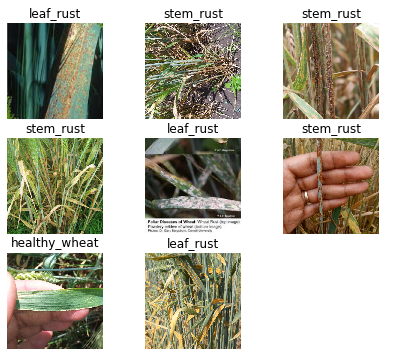

In [9]:
dls.show_batch(max_n=9, figsize=(7,6))

In [10]:
print(dls.vocab)
len(dls.vocab),dls.c

(#3) ['healthy_wheat','leaf_rust','stem_rust']


(3, 3)

In [11]:
opt_func = partial(ranger, mom=0.9, sqr_mom=0.99, eps=1e-6, beta=0.)

In [12]:
learn = Learner(dls, md_ef, metrics=[error_rate, accuracy], opt_func=opt_func, cbs= MixUp()).to_fp16()

(0.001096478197723627, 0.007585775572806597)

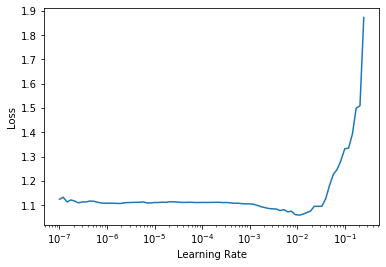

In [13]:
learn.lr_find(suggestions=True)

In [14]:
learn.fit_sgdr(2,4, 1e-3)
#learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.568718,nan,0.875000,0.125000,01:08
1,2.522935,nan,0.750000,0.250000,01:07
2,2.029002,nan,0.625000,0.375000,01:07
3,1.889931,0.983533,0.500000,0.500000,01:07
4,1.829908,1.247521,0.500000,0.500000,01:07
5,1.780008,1.161918,0.500000,0.500000,01:07
6,1.650408,5.874322,0.625000,0.375000,01:07
7,1.606422,0.962132,0.500000,0.500000,01:06
8,1.492633,0.974984,0.500000,0.500000,01:08
9,1.487100,1.009740,0.625000,0.375000,01:08


(1.58489319801447e-07, 2.5118865210060903e-07)

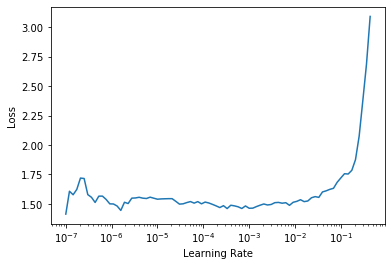

In [15]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [16]:
learn.fit_sgdr(2, 4, slice(1e-8, 1e-4))
#learn.fit_one_cycle(4, slice(1e-8))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.463678,0.977137,0.500000,0.500000,01:06
1,1.531343,0.992706,0.625000,0.375000,01:07
2,1.487075,0.987761,0.625000,0.375000,01:07
3,1.496619,0.971551,0.500000,0.500000,01:07
4,1.486395,0.963959,0.500000,0.500000,01:07
5,1.568751,0.985253,0.500000,0.500000,01:07
6,1.474843,1.313748,0.625000,0.375000,01:07
7,1.513954,1.636537,0.625000,0.375000,01:07
8,1.489427,0.957529,0.500000,0.500000,01:07
9,1.431304,1.052883,0.625000,0.375000,01:07


(0.10964782238006592, 0.9120108485221863)

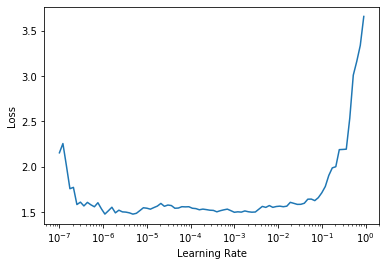

In [17]:
learn.freeze()
learn.lr_find(suggestions=True)

In [18]:
learn.fit_sgdr(2, 4, 1e-9)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.417022,1.344404,0.625000,0.375000,01:06
1,1.422344,0.971318,0.500000,0.500000,01:08
2,1.431482,1.090454,0.625000,0.375000,01:07
3,1.452354,1.059971,0.625000,0.375000,01:07
4,1.479936,1.599815,0.625000,0.375000,01:08
5,1.422824,1.339543,0.625000,0.375000,01:06
6,1.356242,1.153386,0.625000,0.375000,01:08
7,1.379788,2.266673,0.625000,0.375000,01:08
8,1.418653,1.164395,0.625000,0.375000,01:07
9,1.401303,0.969649,0.500000,0.500000,01:08


In [19]:
path = "/home/ubuntu/crop/data_v1/test"
imgs = get_image_files(path)

In [20]:
test_dl = dls.test_dl(imgs)

In [21]:
preds, _ = learn.get_preds(dl=test_dl) 

In [22]:
ids = [i.split(".")[0] for i in os.listdir('/home/ubuntu/crop/data_v1/test')]

In [23]:
submission = pd.DataFrame({'ID': ids, 'leaf_rust': preds[:,0], 'stem_rust': preds[:,1], 'healthy_wheat': preds[:,2]})

In [24]:
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [29]:
submission.to_csv('/home/ubuntu/crop/submission/baseline-reporc2.csv', index=False)

In [31]:
submission.T

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
ID,HK4HT6,ON9PIT,3QZDCW,UD23TV,4H1YI5,566UF3,C00UDR,YUX9Y2,RQH3KT,LT0KA0,...,SU8SJG,RF4O17,YV619U,H091MF,08O2YE,EY1RVI,5KLFGH,ELN2OX,Y7VVJU,TC0TZS
leaf_rust,0.349568,0.351151,0.507676,0.357794,0.344944,0.350401,0.351438,0.3527,0.355152,0.351682,...,0.432723,0.599898,0.34984,0.349901,0.350878,0.356531,0.349698,0.35162,NaN,0.376844
stem_rust,0.508121,0.506451,0.221842,0.50199,0.508426,0.507471,0.506741,0.505836,0.504403,0.506226,...,0.447114,0.318915,0.507773,0.507861,0.506799,0.502789,0.507938,0.506138,NaN,0.500214
healthy_wheat,0.142311,0.142398,0.270482,0.140217,0.14663,0.142129,0.141821,0.141464,0.140444,0.142092,...,0.120163,0.0811874,0.142387,0.142238,0.142322,0.14068,0.142364,0.142241,NaN,0.122942


In [26]:
learn.save("/home/ubuntu/crop/data_v1/models/best-v1")

In [27]:
# 0.221

In [28]:
# 0.230193498540521